In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from rich import print
from rich.panel import Panel
from rich.console import Console
from rich.table import Table
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from typing import Tuple


def preprocess_data_binary(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Preprocess the input DataFrame by separating features and target, and splitting the data into training and validation sets.
    Args:
        df (pd.DataFrame): The input DataFrame containing the dataset.
    Returns:
        Tuple[pd.DataFrame, pd.Series]: A tuple containing the training features (X_train), validation features (X_val), training target (y_train), and validation target (y_val).
    """
    df = df.copy()
    
    # Separate features and target
    X = df.drop(['is_benign', 'category', 'attack'], axis=1)
    y = df['is_benign']
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=37)
    
    return X_train, X_val, y_train, y_val

In [3]:
def evaluate_model(y_true, y_pred, model_name="Model", class_names=None):
    """
    Print comprehensive model evaluation metrics with both rich text output and seaborn heatmap.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    model_name : str, optional
        Name of the model for display purposes
    class_names : list, optional
        List of class names for axis labels
    """
    console = Console()
    
    # Calculate core metrics
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted'),
        "Recall": recall_score(y_true, y_pred, average='weighted'),
        "F1 Score": f1_score(y_true, y_pred, average='weighted')
    }
    
    # Create metrics table
    table = Table(show_header=True, header_style="bold white", box=None)
    table.add_column("Metric", style="cyan")
    table.add_column("Score", justify="right")
    
    # Add metrics rows with color coding
    for metric, value in metrics.items():
        color = "green" if value > 0.8 else "yellow" if value > 0.6 else "red"
        table.add_row(
            metric,
            f"[{color}]{value:.5f}[/{color}]"
        )
    
    # Calculate and plot confusion matrix as heatmap
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap
    plt.figure(figsize=(20, 10))
    if class_names is None:
        class_names = [f"Class {i}" for i in range(cm.shape[0])]
    
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(f'{model_name} - Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Display metrics table
    console.print("\n")
    panel = Panel(
        table,
        title=f"[bold]{model_name} - Performance Metrics[/bold]",
        border_style="white"
    )
    console.print(panel)
    console.print("\n")
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    return metrics

In [5]:
def train_xgboost(df):
    # Split the data
    X_train, X_test, y_train, y_test = preprocess_data_binary(df)
    
    # Initial XGBoost model with balanced class weights
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
        random_state=42,
        n_estimators=100,
        learning_rate=0.1
    )
    
    # Define parameter grid for optimization
    param_grid = {
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9]
    }
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Evaluate the model
    y_pred = best_model.predict(X_test)
    
    # Evaluate the model
    _ = evaluate_model(y_test, y_pred, "XGBoost", ["Benign", "Malicious"])
    
    return best_model

Fitting 5 folds for each of 108 candidates, totalling 540 fits


╭────────────────────────────── XGBoost - Performance Metrics and Confusion Matrix ───────────────────────────────╮
│  Metric       Score                                      Guess \ OG  Class 0  Class 1                           │
│  Accuracy   0.99652                                      Class 0       57438      382                           │
│  Precision  0.99653                                      Class 1          21    57799                           │
│  Recall     0.99652                                                                                             │
│  F1 Score   0.99652                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

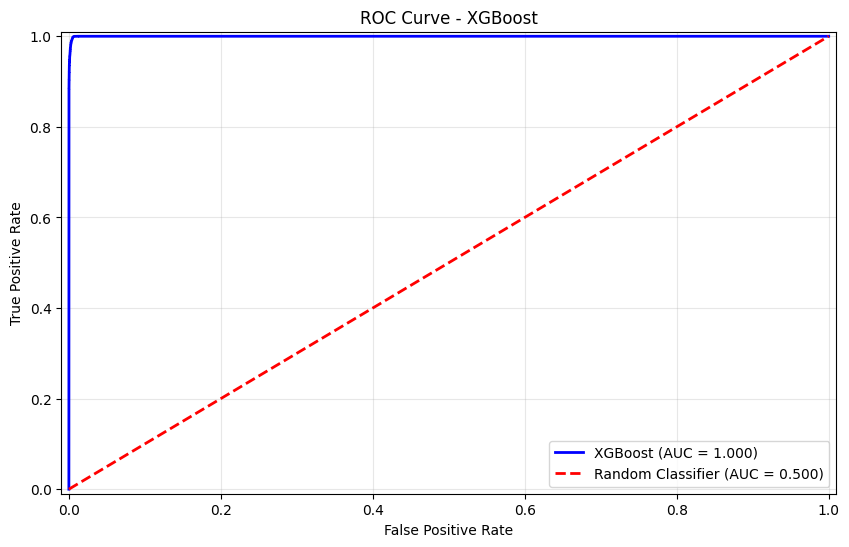

In [6]:
# Load your CSV file
df = pd.read_csv('/kaggle/input/dataset/train_binary.csv')

# Train and evaluate the model
best_model= train_xgboost(df)
best_model.save_model('xgboost_binary.json')